In [1]:
import numpy as np
import requests
import umap
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer
import json
import matplotlib.pyplot as plt

/home/vivek/miniforge3/envs/AMS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sample data
transcript = [
    {"speaker": "Speaker 1", "utterance": "Morning everyone. Let’s start with product roadmap updates.", "start": 0.0, "end": 3.0},
    {"speaker": "Speaker 2", "utterance": "The dev team finalized features for the Q2 release. We're on track.", "start": 3.1, "end": 7.0},
    {"speaker": "Speaker 3", "utterance": "QA flagged a few bugs that might push timelines by a week.", "start": 7.1, "end": 10.0},
    {"speaker": "Speaker 1", "utterance": "Okay, let's make sure we plan buffers. Now, switching to marketing.", "start": 10.1, "end": 13.0},
    {"speaker": "Speaker 2", "utterance": "We’re planning a social media push around mid-May, targeting Gen Z.", "start": 13.1, "end": 16.0},
    {"speaker": "Speaker 3", "utterance": "Are we using influencers again?", "start": 16.1, "end": 18.0},
    {"speaker": "Speaker 2", "utterance": "Yes, and we’re also trying TikTok ads for the first time.", "start": 18.1, "end": 21.0},
    {"speaker": "Speaker 1", "utterance": "Alright. One last thing — company offsite. Any preferences?", "start": 21.1, "end": 24.0},
    {"speaker": "Speaker 3", "utterance": "Beach would be great.", "start": 24.1, "end": 25.5},
    {"speaker": "Speaker 2", "utterance": "Mountains! Better Wi-Fi and fewer distractions.", "start": 25.6, "end": 27.0},
    {"speaker": "Speaker 1", "utterance": "Noted. Let's finalize next week.", "start": 27.1, "end": 28.5},
    {"speaker": "Speaker 1", "utterance": "Now, any blockers from legal or compliance?", "start": 28.6, "end": 31.0},
    {"speaker": "Speaker 3", "utterance": "Yes, the new GDPR changes could affect user analytics tracking.", "start": 31.1, "end": 34.0},
    {"speaker": "Speaker 2", "utterance": "That might impact our data dashboards — we’ll need revisions.", "start": 34.1, "end": 37.0},
    {"speaker": "Speaker 1", "utterance": "Got it. Let’s loop in the legal team tomorrow.", "start": 37.1, "end": 39.0},
    {"speaker": "Speaker 1", "utterance": "Finally, hiring. We still need two backend engineers.", "start": 39.1, "end": 42.0},
    {"speaker": "Speaker 3", "utterance": "We have three interviews lined up next week.", "start": 42.1, "end": 45.0},
    {"speaker": "Speaker 2", "utterance": "Also, we’re shortlisting frontend candidates this week.", "start": 45.1, "end": 48.0}
]


In [3]:


# Preprocessing step to remove disfluencies and clean text (skip this for now as the focus is on DBSCAN)
def preprocess_text(text):
    return text  # assuming text is already clean for simplicity


In [4]:
# Generate embeddings for utterances (use a dummy embedding here for testing, assuming they are vectors)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def generate_embeddings(utterances):
    texts = utterances
    embeddings = embedding_model.encode(texts, show_progress_bar=True)
    return np.array(embeddings)

In [5]:
# Prepare embeddings for the transcript
utterances = [entry['utterance'] for entry in transcript]
embeddings = generate_embeddings(utterances)

# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=2, metric='cosine', random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embeddings)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='euclidean')
labels = dbscan.fit_predict(reduced_embeddings)

Batches: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]
/home/vivek/miniforge3/envs/AMS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vivek/miniforge3/envs/AMS/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


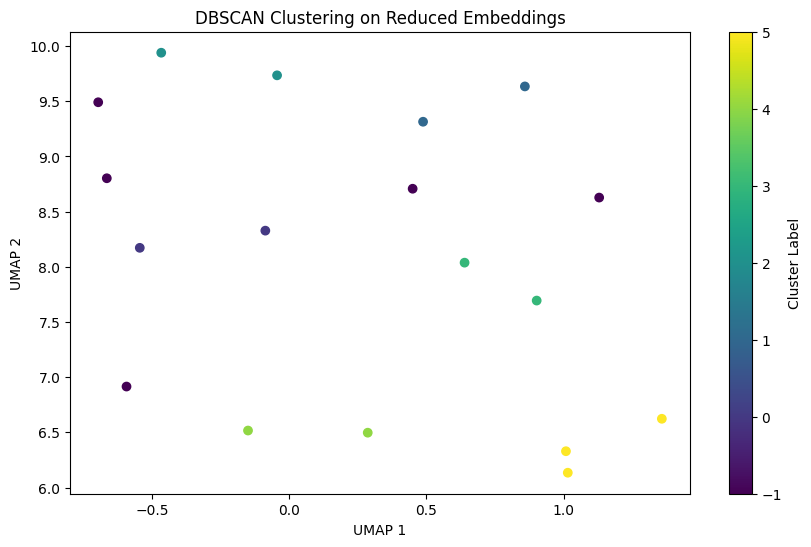

{-1: ['Morning everyone. Let’s start with product roadmap updates.',
  'Alright. One last thing — company offsite. Any preferences?',
  'Now, any blockers from legal or compliance?',
  'Yes, the new GDPR changes could affect user analytics tracking.',
  'That might impact our data dashboards — we’ll need revisions.'],
 0: ["The dev team finalized features for the Q2 release. We're on track.",
  'QA flagged a few bugs that might push timelines by a week.'],
 1: ["Okay, let's make sure we plan buffers. Now, switching to marketing.",
  'Yes, and we’re also trying TikTok ads for the first time.'],
 2: ['We’re planning a social media push around mid-May, targeting Gen Z.',
  'Are we using influencers again?'],
 3: ['Beach would be great.',
  'Mountains! Better Wi-Fi and fewer distractions.'],
 4: ["Noted. Let's finalize next week.",
  'Got it. Let’s loop in the legal team tomorrow.'],
 5: ['Finally, hiring. We still need two backend engineers.',
  'We have three interviews lined up next wee

In [6]:
# Visualize the clustering results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN Clustering on Reduced Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster Label")
plt.show()

# Return the segment labels for each utterance
segments = {}
for idx, label in enumerate(labels):
    if label not in segments:
        segments[label] = []
    segments[label].append(utterances[idx])

segments


# Testing for API